## Calculating displacement due to faulting

This notebook will calculate _displacement_ at specified points due to slip on a fault. 

In [1]:
# Import libraries
import pandas as pd
import geopandas as gpd
import numpy as np # Numerical analysis
import gmsh # Creation of fault models
import meshio # Interaction between fault model files and Python
import matplotlib.pyplot as plt # Visualize 
from pyproj import Proj
import pyproj
import h5py
import scipy #for interpolation
from scipy.interpolate import NearestNDInterpolator 
from geopandas import geoseries
%matplotlib widget

In [2]:
# Define some basic coordinate transformation functions
GEOID = pyproj.Geod(ellps="WGS84")
KM2M = 1.0e3
RADIUS_EARTH = np.float64((GEOID.a + GEOID.b) / 2)

def sph2cart(lon, lat, radius):
    lon_rad = np.deg2rad(lon)
    lat_rad = np.deg2rad(lat)
    x = radius * np.cos(lat_rad) * np.cos(lon_rad)
    y = radius * np.cos(lat_rad) * np.sin(lon_rad)
    z = radius * np.sin(lat_rad)
    return x, y, z

def cart2sph(x, y, z):
    azimuth = np.arctan2(y, x)
    elevation = np.arctan2(z, np.sqrt(x ** 2 + y ** 2))
    r = np.sqrt(x ** 2 + y ** 2 + z ** 2)
    return azimuth, elevation, r

def wrap2360(lon):
    lon[np.where(lon < 0.0)] += 360.0
    return lon

### Read in mesh and make basic geometry plots

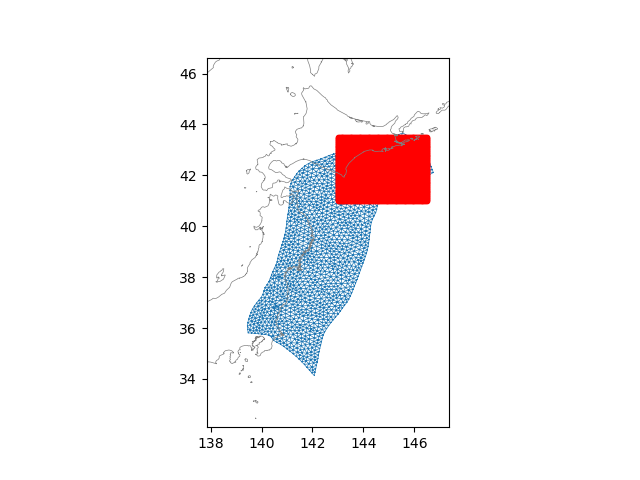

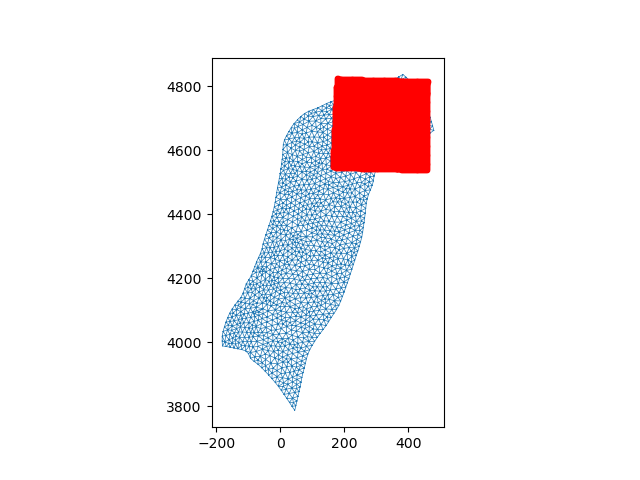

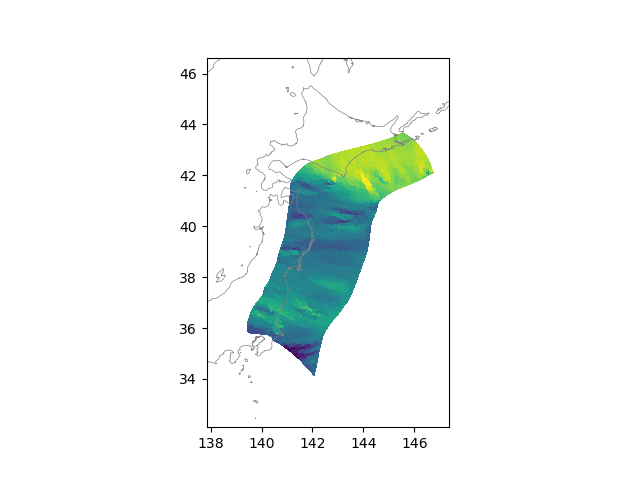

In [3]:
# Read in source fault
# filename = "cascadia.msh"
filename = "Japan.msh"
mesh = dict()
meshobj = meshio.read(filename)
mesh["file_name"] = filename
mesh["points"] = meshobj.points
mesh["verts"] = meshio.CellBlock("triangle", meshobj.get_cells_type("triangle")).data
ntri = len(mesh["verts"])

# Expand mesh coordinates
mesh["lon1"] = mesh["points"][mesh["verts"][:, 0], 0]
mesh["lon2"] = mesh["points"][mesh["verts"][:, 1], 0]
mesh["lon3"] = mesh["points"][mesh["verts"][:, 2], 0]
mesh["lat1"] = mesh["points"][mesh["verts"][:, 0], 1]
mesh["lat2"] = mesh["points"][mesh["verts"][:, 1], 1]
mesh["lat3"] = mesh["points"][mesh["verts"][:, 2], 1]
mesh["dep1"] = mesh["points"][mesh["verts"][:, 0], 2]
mesh["dep2"] = mesh["points"][mesh["verts"][:, 1], 2]
mesh["dep3"] = mesh["points"][mesh["verts"][:, 2], 2]
mesh["centroids"] = np.mean(mesh["points"][mesh["verts"], :], axis=1)

# Cartesian coordinates in meters
mesh["x1"], mesh["y1"], mesh["z1"] = sph2cart(
    mesh["lon1"],
    mesh["lat1"],
    RADIUS_EARTH + KM2M * mesh["dep1"],
)
mesh["x2"], mesh["y2"], mesh["z2"] = sph2cart(
    mesh["lon2"],
    mesh["lat2"],
    RADIUS_EARTH + KM2M * mesh["dep2"],
)
mesh["x3"], mesh["y3"], mesh["z3"] = sph2cart(
    mesh["lon3"],
    mesh["lat3"],
    RADIUS_EARTH + KM2M * mesh["dep3"],
)
# Cartesian triangle centroids
mesh["x_centroid"] = (mesh["x1"] + mesh["x2"] + mesh["x3"]) / 3.0
mesh["y_centroid"] = (mesh["y1"] + mesh["y2"] + mesh["y3"]) / 3.0
mesh["z_centroid"] = (mesh["z1"] + mesh["z2"] + mesh["z3"]) / 3.0

# Cross products for orientations
tri_leg1 = np.transpose([np.deg2rad(mesh["lon2"] - mesh["lon1"]), np.deg2rad(mesh["lat2"] - mesh["lat1"]), (1 + KM2M * mesh["dep2"] / RADIUS_EARTH) - (1 + KM2M * mesh["dep1"] / RADIUS_EARTH)])
tri_leg2 = np.transpose([np.deg2rad(mesh["lon3"] - mesh["lon1"]), np.deg2rad(mesh["lat3"] - mesh["lat1"]), (1 + KM2M * mesh["dep3"] / RADIUS_EARTH) - (1 + KM2M * mesh["dep1"] / RADIUS_EARTH)])
mesh["nv"] = np.cross(tri_leg1, tri_leg2)
azimuth, elevation, r = cart2sph(mesh["nv"][:, 0], mesh["nv"][:, 1], mesh["nv"][:, 2])
mesh["strike"] = wrap2360(-np.rad2deg(azimuth))
mesh["dip"] = 90 - np.rad2deg(elevation)
mesh["dip_flag"] = mesh["dip"] != 90

# Set up grid where vertical displacement will be calculated

# Cascadia range
# xs = np.linspace(237, 240, 100)
# ys = np.linspace(40, 50, 100)

# Hokkaido range
xs = np.linspace(143, 146.5, 100)
ys = np.linspace(41, 43.5, 100)

# Reshape grid
obsx, obsy = np.meshgrid(xs, ys)
pts = np.array([obsx, obsy, 0 * obsy]).reshape((3, -1)).T.copy()

# Convert the fault and grid coordinates to Cartesian

# Set up transformation
lon_corr = 1
# Check longitude convention of mesh
if np.max(xs) > 180:
    lon_corr = 0

utmzone=int(32700-(np.sign(np.mean(ys))+1)/2 * 100+np.floor((lon_corr*180 + np.mean(xs))/6) + 1)
target_crs = 'epsg:'+str(utmzone) # Coordinate system of the file
source_crs = 'epsg:4326' # Global lat-lon coordinate system
latlon_to_utm = pyproj.Transformer.from_crs(source_crs, target_crs)

# Convert coordinates
faultxy = np.array(latlon_to_utm.transform(mesh["points"][:, 1], mesh["points"][:, 0])).T/1e3
gridxy = np.array(latlon_to_utm.transform(pts[:, 1], pts[:, 0])).T/1e3 

cart_fault_pts = np.zeros_like(mesh["points"])
cart_fault_pts[:, 0:2] = faultxy
cart_fault_pts[:, 2] = mesh["points"][:, 2]
cart_grid_pts = np.zeros_like(pts)
cart_grid_pts[:, 0:2] = gridxy
cart_grid_pts[:, 2] = pts[:, 2]

#good place to calc area, property of every single element, in sq km, so multiply by 1,000,000 so it is in terms of meters (1000 m x 1000 m)
cart_leg1 = cart_fault_pts[mesh["verts"][:,1]] - cart_fault_pts[mesh["verts"][:,0]]
cart_leg2 = cart_fault_pts[mesh["verts"][:,2]] - cart_fault_pts[mesh["verts"][:,1]]
mesh["cart_nv"] = np.cross(cart_leg1, cart_leg2)

mesh["area"] = ((np.linalg.norm(mesh["cart_nv"],axis=1))/2) * (1e6)
# Plot the source fault

# Setting up axis limits
xmin = np.mean(mesh["points"][:, 0]) - 3*np.std(mesh["points"][:, 0])
xmax = np.mean(mesh["points"][:, 0]) + 3*np.std(mesh["points"][:, 0])
ymin = np.mean(mesh["points"][:, 1]) - 3*np.std(mesh["points"][:, 1])
ymax = np.mean(mesh["points"][:, 1]) + 3*np.std(mesh["points"][:, 1])
# Read in coastline file
coast = pd.read_csv("coastline.csv")
# Define the figure and its axis
fig, ax = plt.subplots()
# Draw the fault
ax.triplot(mesh["points"][:, 0], mesh["points"][:, 1], mesh["verts"], linewidth=0.5)
# Add grid points
ax.plot(pts[:, 0], pts[:, 1], '.r')
# Add coastline
ax.plot(coast.lon+360*(1-lon_corr), coast.lat, color="gray", linewidth=0.5)
ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), aspect='equal')
plt.show()

# Make another plot, showing fault and grid in Cartesian coordinates
fig, ax = plt.subplots()
ax.triplot(cart_fault_pts[:,0], cart_fault_pts[:, 1], mesh["verts"], linewidth=0.5)
ax.plot(cart_grid_pts[:, 0], cart_grid_pts[:, 1], '.r')
ax.set(aspect="equal")
plt.show()

# Show elements colored by strike
fig, ax = plt.subplots()
# Draw the fault
ax.tripcolor(mesh["points"][:, 0], mesh["points"][:, 1], mesh["verts"], facecolors=mesh["strike"])
# Add coastline
ax.plot(coast.lon+360*(1-lon_corr), coast.lat, color="gray", linewidth=0.5)
ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), aspect='equal')
plt.show()

# #Show elements colored by depth
# fig, ax = plt.subplots()
# fo = ax.tripcolor(mesh["points"][:, 0], mesh["points"][:, 1], mesh["verts"], facecolors=mesh["centroids"][:,2])
# plt.colorbar(fo) #uses info from plotted object to create scale
# # Add coastline
# ax.plot(coast.lon+360*(1-lon_corr), coast.lat, color="gray", linewidth=0.5)
# ax.title.set_text("Fault Colored By Depth (km)")
# ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), aspect='equal')
# plt.show()


In [4]:
### INTERPOLATION OF USGS TOKACHI OKI DATA ONTO TRIANGLE MESH ###
# Read file
f = gpd.read_file("FFM.geojson", engine="pyogrio") #specify the engine because it keeps trying to use fiona
# #Print a list of the variables
print(f.keys())

rake = np.array(f["rake"])

# # Type = geopandas.geoseries.GeoSeries
print(type(f["geometry"]))

#convert the polygon coordinate information into a single centroid value for each rectangle
rectangle_centroids = f["geometry"].centroid 
#error message for geographic coordinate system, but it's likely not problematic because they graph along the expected mesh

#separate centroid information into an array of points with [lon, lat]
points_lon = np.array(rectangle_centroids.x)
points_lat = np.array(rectangle_centroids.y)
points = np.column_stack((points_lon, points_lat))
points_cart = np.array(latlon_to_utm.transform(points[:,1], points[:,0])).T/1e3

## values we want to interpolate from the old rectangle grid to the new/standard triangle mesh ##
slip_values = f['slip'] #slip values of the rectangles 
rake_values = f['rake']

goal_points = mesh["centroids"] #the points that we want to interpolate the USGS data onto

#NEAREST NEIGHBOR method of interpolation
interpolated = NearestNDInterpolator((points[:,0], points[:,1]), slip_values)
new_grid_slip = interpolated(goal_points[:,0], goal_points[:,1]) #x, y

interp_rake = NearestNDInterpolator((points[:,0], points[:,1]), rake_values)
new_rake_vals = interp_rake(goal_points[:,0], goal_points[:,1])

# #check to make sure the centroid points are close/valid with our mesh
# fig, ax = plt.subplots()
# ax.plot(points[:,0], points[:,1], '.')
# ax.plot(goal_points[:,0], goal_points[:,1], '.')
# plt.legend()
# plt.show()


Index(['fill', 'fill-opacity', 'rake', 'rise', 'sf_moment', 'slip',
       'stroke-width', 'trup', 'x==ew', 'y==ns', 'geometry'],
      dtype='object')
<class 'geopandas.geoseries.GeoSeries'>


/var/folders/7c/8db84z1953v2yvj0hb957l_h0000gp/T/ipykernel_1855/247228127.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  rectangle_centroids = f["geometry"].centroid


### Calculate displacement

In [6]:
# Calculate the mathematical relationship between unit fault slip and displacement
# This takes a bit of time, but it only needs to be done once if your fault and grid don't change

import cutde.halfspace as cutde

disp_mat = cutde.disp_matrix(obs_pts=cart_grid_pts, tris=cart_fault_pts[mesh["verts"]], nu=0.25)

# Write to HDF5 file
hf = h5py.File("disp_matJapan.h5", "w")
hf["disp_matJapan"] = disp_mat
hf.close()

In [5]:
# Read disp_mat from file

hf = h5py.File('disp_matJapan.h5', 'r')
disp_mat = np.array(hf["disp_matJapan"])
hf.close()

In [6]:
def radgauss(x0, y0, a, x, y, c):
# 
# RADGAUSS calculates a radial Gaussian distribution.
# 
# S = RADGAUSS(X0, Y0, A, X, Y, C) uses the formula:
# 
# S(Xi, Yi) = A exp(-Ri^2/2C^2)
# 
# to calculate the value S at point (Xi,Yi), which is located a distance
# Ri from point (X0,Y0), where the value is A.  C represents a Gaussian 
# curvature parameter: larger values of C produce more abrupt changes in
# value with distance.
# 
# X0, Y0 represent the x,y coordinates of the point of maximum magnitude A.
# X and Y are n x 1 arrays containing the x,y coordinates of all points at
# which the value S should be calculated.  C is a single value that applies
# to the entire calculation.
# 
# If C is a 2-element vector, the pattern will not be radial but elliptical,
# with the first element of C giving the curvature in the X direction and the
# second giving the curvature in Y:
# 
# S(Xi, Yi) = A exp( [ -(Xi-X0)^2 / 2C[0]^2 ] + [ -(Yi-Y0)^2 / 2C[1]^2] )
# 
# If C is a 3-element vector, an elliptical pattern will result, and the
# ellipse will be rotated C[2] degrees from the y-axis, where a positive 
# number gives a clockwise rotation.
    c = np.array(c)
    if np.size(c) == 1:
        r = np.sqrt((x-x0)**2+(y-y0)**2) # calculate distances
        s = a*np.exp(-r**2/(2*c**2)) # calculate Gaussian value
    elif np.size(c) == 2:
        s = a*np.exp((-(x-x0)**2./(2*c[0]**2)) + (-(y-y0)**2./(2*c[1]**2)))
    elif np.size(c) == 3:
        ang = np.deg2rad(c[2])
        rot = np.array([[np.cos(ang), -np.sin(ang)], [np.sin(ang), np.cos(ang)]])
        coords = np.vstack((np.hstack((x.T, x0)), np.hstack((y.T, y0))))
        rcoords = rot.dot(coords)
        s = a*np.exp((-(rcoords[0, :-1]-rcoords[0, -1])**2/(2*c[0]**2)) + (-(rcoords[1, :-1]-rcoords[1, -1])**2/(2*c[1]**2)))

    return s  

## Input slip shape and center coordinates of slip before graphing displacement

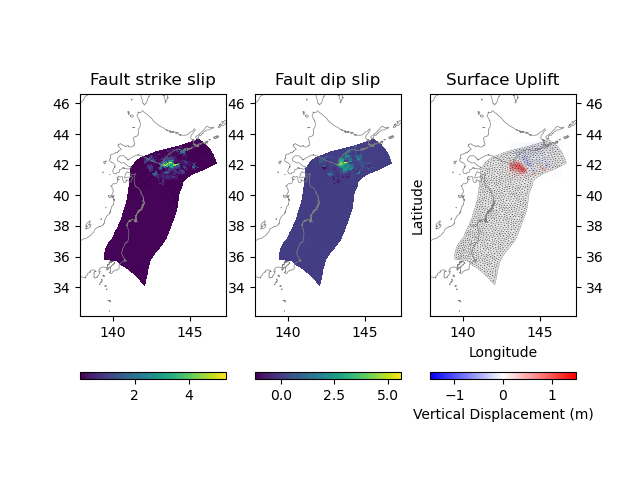

[0.92527355]


In [7]:
# Uniform fault slip distribution 
# slip = np.zeros_like(mesh["verts"])
# slip[:, 1] = 1 # Uniform dip-slip

# Radial slip distribution 

# Center coordinates of slip distribution
lon_center = 142.4 #Tok: 143.4 ; 1982: 142.578
lat_center = 42.3 #Tok: 42.45 ; 1982: 42.172
sub_az = 290 #angle of the subduction azimuth 

# Stretch of slip gradient in x, y plus rotation angle
slip_shape = np.array([0.15, .75, 150])
#Tok: [0.025, 0.12, 145]
#1892: [0.05, 0.08, 230]

#s only magnitude, not direction for each triangle
#2.5 means 2.5 m of slip is the max
# s = radgauss(lon_center, lat_center, 1.6, mesh["centroids"][:, 0], mesh["centroids"][:, 1], slip_shape)
# mesh["slip"] = s 
s = new_grid_slip
mesh["rake"] = new_rake_vals
mesh["slip"] = s

# #separate the strike slip and the dip slip:
strike_slip = 1* s*(np.sin(np.deg2rad(mesh["strike"] - mesh["rake"])))
dip_slip = -1* s*(np.cos(np.deg2rad(mesh["strike"] - mesh["rake"])))

mesh["ss"] = strike_slip
mesh["ds"] = dip_slip
#calculate the moment
#moment = rigidity x area x slip
rigidity = 3e10 #N / m^2
moment = rigidity * (mesh["area"]) * s
total_moment = sum(moment) # in N / m^2

#moment magnitude calculation
#Moment Magnitude (MW) = 2/3 log10(MO) - 9.1
moment_mag =(2/3) * (np.log10(total_moment) - 9.1)

# #calculates dip slip. Needs to be positive?
# s_dip = (s * np.sin(np.deg2rad(sub_az - mesh["strike"]))) 

# #strike slip calculation, np.cos needs radians
# s_strike = s * (-1) * (np.cos(np.deg2rad(sub_az - mesh["strike"])))


# # Create full slip distribution, adding radial slip as dip-slip #USE FOR HIDAKA
# slip = np.vstack((np.zeros_like(s), s, np.zeros_like(s))).T

#creating slip distribution with strike-slip and dip-slip separated #USE FOR SUBDUCTION ZONE
slip = np.vstack((strike_slip, dip_slip, np.zeros_like(s))).T

# Calculate predicted displacement at grid points that arises from fault slip
pred_disp = disp_mat.reshape((-1, 3*ntri)).dot(slip.reshape(3*ntri, 1))


plt.close('all')
# Visualize the slip and displacement pattern HOKKAIDO graph

fig, ax = plt.subplots(1, 3) #when it was 1, 2 it was fault slip and grid displacement, but if I add third can do (strike slip, dip slip, grid displacement)
sso = ax[0].tripcolor(mesh["points"][:, 0], mesh["points"][:, 1], mesh["verts"], facecolors=slip[:,0])
dso = ax[1].tripcolor(mesh["points"][:, 0], mesh["points"][:, 1], mesh["verts"], facecolors=slip[:,1])
fig.colorbar(sso, ax=ax[0], orientation='horizontal')
fig.colorbar(dso, ax=ax[1], orientation='horizontal')
ax[0].plot(coast.lon+360*(1-lon_corr), coast.lat, color="gray", linewidth=0.5)
ax[1].plot(coast.lon+360*(1-lon_corr), coast.lat, color="gray", linewidth=0.5)
ax[1].set(xlim=(xmin, xmax), ylim=(ymin, ymax), aspect='equal')
ax[0].set(xlim=(xmin, xmax), ylim=(ymin, ymax), aspect='equal')
ax[0].title.set_text("Fault strike slip") #graph 1
ax[1].title.set_text("Fault dip slip") #graph 2
# Show uplift (pred_disp[2::3])

# #HIDAKA graph (radial slip not strike/dip separate)
# fig, ax = plt.subplots(1, 2) #HIDAKA radial slip not strike/dip
# rso = ax[0].tripcolor(mesh["points"][:,0], mesh["points"][:,1], mesh["verts"], facecolors=s)
# cbar1 = fig.colorbar(rso, ax=ax[0], orientation='horizontal')
# cbar1.set_label("Slip (m)")
# ax[0].plot(coast.lon+360*(1-lon_corr), coast.lat, color="gray", linewidth=0.5)
# ax[0].set(xlim=(xmin, xmax), ylim=(ymin, ymax), aspect='equal')
# ax[0].title.set_text("Fault Slip") #graph 1
# ax[0].set_ylabel("Latitude")
# ax[0].set_xlabel("Longitude")

# #read in the reference fault 
# hf = h5py.File('miniReferenceDisp.h5', 'r')
# ref_pred_disp = np.array(hf["miniReferenceDisp"])
# hf.close()

# Get limits of displacement that is being plotted
#pred disp 2 means vertical displacement at the grid points (0 is east west and 1 is north/south) after matrix multiplication
#plot_disp = (pred_disp[2::3] - ref_pred_disp[2::3])
plot_disp = (pred_disp[2::3])
max_mag = np.max([np.max(plot_disp), np.abs(np.min(plot_disp))])
#gdo = ax[2].pcolormesh(obsx, obsy, plot_disp.reshape(np.shape(obsx)), shading="auto", cmap="bwr", vmin=-max_mag, vmax=max_mag) #we can assume maxSlip=1, pos=red, neg=blue
#set color scale to being UNIFORM not dependent on max for that run/trial
#used to be vmin=-max_mag, vmax=max_mag, changing it to -0.5 = min, 0.5 = max
gdo = ax[2].pcolormesh(obsx, obsy, plot_disp.reshape(np.shape(obsx)), shading="auto", cmap="bwr", vmin=-1.5, vmax=1.5)
#fig.colorbar(gdo, ax=ax[2], orientation='horizontal')
cbar = fig.colorbar(gdo, ax=ax[2], orientation='horizontal')
cbar.set_label("Vertical Displacement (m)")
# Draw the fault
#ax[2].triplot(mesh["points"][:, 0], mesh["points"][:, 1], mesh["verts"], linewidth=0.25, color='k')
ax[2].triplot(mesh["points"][:,0], mesh["points"][:,1], mesh["verts"], linewidth=0.1, color='k')
# Add coastline
# ax[2].plot(coast.lon+360*(1-lon_corr), coast.lat, color="gray", linewidth=0.5)
# ax[2].set(xlim=(xmin, xmax), ylim=(ymin, ymax), aspect='equal')
# ax[2].yaxis.tick_right()
# ax[2].title.set_text("Grid displacement")
ax[2].plot(coast.lon+360*(1-lon_corr), coast.lat, color="gray", linewidth=0.5)
ax[2].set(xlim=(xmin, xmax), ylim=(ymin, ymax), aspect='equal')
ax[2].yaxis.tick_right()
plt.ylabel("Latitude")
plt.xlabel("Longitude")
ax[2].title.set_text("Surface Uplift")
plt.show()

print(max(pred_disp[2::3]))


### output information about slip event (moment, moment magnitude, average slip, slip dimensions, etc.)

In [12]:
### DON"T FORGET TO CHANGE THE DIP VALUE FOR DOWNDIP WIDTH MEASUREMENT ###
dip = np.radians(42.4) #42.2 for Ishikari, 59.5 for Tokachi
print("***ISHIKARI EMPIRICAL MATCH***:")
print("moment magnitude: ", moment_mag)
print("moment: ", total_moment * 1e7 ) #moment is in N / m^2, so multiply by 10^7
#print("Reported moment of 2.7e26 dyne-cm")
#print("simulated moment - reported moment: ", (total_moment*1e7) - 2.7e26)

#dividing by 1000000 takes the area from m^2 back to km^2
area = np.sum(mesh["area"]) / 1000000

#boolean mask is used to sort/index a nparray based off of if a given condition is true
boolean_mask = mesh["slip"] > 0.2
slipArea = np.sum(mesh["area"][boolean_mask]) / 1000000

num_elements = mesh["slip"][boolean_mask].size
avg_slip = np.sum(mesh["slip"][boolean_mask]) / num_elements
print("average slip: ", avg_slip)

###     SLIP DIMENSIONS     ###
#multiply by roughly 100 km
#the centroids have the latitude,longitude,and depth of the triangles
slip_location = mesh["centroids"][boolean_mask]

#rotate the coordinates so that max and min lon/lat are indicative of dimensions
#otherwise the tilted shape will have max lon/lat as the same point so the length is diagonal instead of horizontal
angle = np.radians(slip_shape[2]-15)
rot = np.array([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) 
coords = np.vstack(((slip_location[:,0].T - lon_center), (slip_location[:,1].T - lat_center)))
rcoords = rot.dot(coords) 

#put the coords back into vertical stacks
slip_coords = rcoords.T

#Longitude information
max_lon = max(slip_coords[:, 0])
min_lon =  min(slip_coords[:, 0])
lon_range = (max_lon - min_lon)

#Latitude information
max_lat = max(slip_coords[:,1])
min_lat = min(slip_coords[:,1])
lat_range = (max_lat - min_lat)

# #distance (length and width)
length = (lon_range)*100  #multiplication by 100 is a rough conversion from latitudes to km
width = ((lat_range) / np.cos(dip))*100


print()
# print("longitude range: ", lon_range)
# print("latitude range: ", lat_range)
print("length (km): ", length)
print("width (km): ", width)
print()


#print("area(km^2): ", area)
print("slip area (km^2): ", slipArea)
#print("area - slip area: ", area - slipArea)


fig, ax = plt.subplots()
ax.plot(coords[0,:], coords[1,:], '.', label="original")
ax.plot(rcoords[0,:], rcoords[1,:], '.', label="rotated")
plt.legend()
plt.show()
#1 is y direction
#0 is x direction



    

## Create array of fault information to save as a CSV for geoclaw reading

In [30]:
##Create CSV file for the fault mesh to read into geoclaw from ishikari fault/beginning with a triangle mesh
# follows the format: node1(lon,lat,z[km]) , node2(lon,lat,z[km]) , node3(lon,lat,z[km]) , strike, dip

shape = (mesh["lon1"].size, 11)
values = np.empty(shape) #empty array the correct size, #of rows as subfaults (triangle mesh elements)
centroids = mesh["centroids"]

#subfault number
for i in range(int(mesh["lon1"].size)):
    values[i,0] = int(i+1)

# ##CENTROIDS
# values[:, 1] = centroids[:,0] #centroid longitude
# values[:, 2] = centroids[:,1] #centroid latitude
# values[:, 3] = centroids[:,2] #centroid depth (z)

##NODES
values[:, 0] = mesh["lon1"]
values[:, 1] = mesh["lat1"]
values[:, 2] = mesh["dep1"]
values[:, 3] = mesh["lon2"]
values[:, 4] = mesh["lat2"]
values[:, 5] = mesh["dep2"]
values[:, 6] = mesh["lon3"]
values[:, 7] = mesh["lat3"]
values[:, 8] = mesh["dep3"]

#MEAN VERTEX LENGTH, AREA, STRIKE, DIP
# shape2 = (mesh["area"].size,)
# values[:, 13] = np.full(shape2, 5) #characteristic length from gmsh 
# values[:, 14] = mesh["area"]
values[:, 9] = mesh["strike"]
values[:, 10] = mesh["dip"]

#RUPTURE PARAMETERS
shape3 = (mesh["slip"].size,2)
ishikari_rupture2 = np.empty(shape3)
ishikari_rupture2[:,0] = np.zeros_like(mesh["slip"])
ishikari_rupture2[:,1] = mesh["slip"] #all dip slip

In [48]:
# Tokachi fault from USGS rectangle into triangle for geoclaw /beginning with a rectangle mesh
# fault: lon1, lat1, dep1, lon2, lat2, dep2, lon3, lat3, dep3, rake
# rupture: slip, rise time, rupture time

# Read file
f = gpd.read_file("FFM.geojson", engine="pyogrio") #specify the engine because it keeps trying to use fiona
print(f.keys())
rise = np.array(f["rise"])
rupt_time = np.array(f["trup"])
rake = np.array(f["rake"])
slip = np.array(f["slip"])

num_elem = len(f.count_geometries())
rect_coords = f["geometry"].get_coordinates(include_z=True)
tri_coords = np.empty((2*num_elem, 10))
rupt_param = np.empty((2*num_elem, 3))
m = 0 # indexing

for i in range(int(num_elem)):
    temp = np.array(rect_coords.loc[i])
    tri_coords[m,[0,1,2]] = temp[0,:]
    tri_coords[m,[3,4,5]] = temp[1,:]
    tri_coords[m,[6,7,8]] = temp[3,:]
    tri_coords[m,9] = rake[i]; m+=1 #reads in the first three vertices and rake
    tri_coords[m,[0,1,2]] = temp[1,:]
    tri_coords[m,[3,4,5]] = temp[2,:]
    tri_coords[m,[6,7,8]] = temp[3,:]
    tri_coords[m,9] = rake[i]; m+=1

tri_coords[:,[2,5,8]] = tri_coords[:,[2,5,8]] / -1000 ## EXPORT tri_coords as a CSV file from jupyter variables tab

n=0 #indexing separate rom loop variable, because 2 triangles for every rectangle makes the
# rows a little difficult to keep track of if one variable is used for both

# read in rupture parameters
for j in range(int(num_elem)):
    rupt_param[n, 0] = slip[j]
    rupt_param[n, 1] = rise[j]
    rupt_param[n, 2] = rupt_time[j]
    n += 1 # both triangles get the same slip/rise
    rupt_param[n, 0] = slip[j]
    rupt_param[n, 1] = rise[j] 
    rupt_param[n, 2] = rupt_time[j] ; n+=1 ## Export rupt_param as a CSV from jupyter variables tab


Index(['fill', 'fill-opacity', 'rake', 'rise', 'sf_moment', 'slip',
       'stroke-width', 'trup', 'x==ew', 'y==ns', 'geometry'],
      dtype='object')


## Set up coordinates for listric fault meshing by reading in points and inputing depth and dip

In [9]:
#read in fault points ## REMEMBER TO FILL IN dip1 AND dip2, locking_depth1 AND locking_depth2, DO NOT FORGET HALF THE INFORMATION
filename = 'TokDeep'
locking_depth1 = 10
dip1 = 59.5
dip2 = 59.5
locking_depth2 = 20 #2 kilometers first depth + 8 = 10km total

coords = pd.read_csv("./TokachiPlainTrace.csv") #../ shortcut for go up one folder and look
coords = coords[::-1]
coords["depth"] = np.zeros_like(coords["lon"])
n_points = np.shape(coords)[0] #number of points
segment = dict() #key value pair, String for key and nd.array for value

# Use top and bottom coordinates to make a mesh
clen = 5 #small elements = better complexity but longer time for calculations

#new code for bottom fault values, by segments

#starting and ending points of segments 
#the np.array in front is NOT optional
segment["lon1"] = (np.array(coords[:-1:].copy()))[:,0] #takes everything except the last set of coordinates, then takes the longitude column only
segment["lat1"] = (np.array(coords[:-1:].copy()))[:,1] #takes everything except last coordinates, then takes latitude column
segment["lon2"] = (np.array(coords[1::]).copy())[:,0]
segment["lat2"] = (np.array(coords[1::]).copy())[:,1] #everything except first set of coordinates, then the latitude column


#Find the azimuth for each section and convert it to degrees
#segment["azimuth"] = ...
segment["azimuth"], __, segment_distance = (GEOID.inv(segment["lon1"], segment["lat1"], segment["lon2"], segment["lat2"]))


#the projected width from the initial point, based on angle of dip, and the locking depth?
#making it an array the same shape as segment_start, but they're all the same value because I only have the one dip
segment["projected width"] = np.full_like(segment["lon1"], locking_depth1/np.tan(np.deg2rad(dip1)))

#calculate new endpoints, do it twice for each segement (starting pt and ending pt), lon1, lat 1, dip_direction, p_width
#locking_depth = km, 1e3 changes it to m so that it fits in world shape for geoid
segment["bottom lon1"], segment["bottom lat1"], _ = (GEOID.fwd(segment["lon1"], segment["lat1"], (segment["azimuth"] - 90), 1e3*segment["projected width"]))
segment["bottom lon2"], segment["bottom lat2"], _ = (GEOID.fwd(segment["lon2"], segment["lat2"], (segment["azimuth"] - 90), 1e3*segment["projected width"]))


#average out middle duplicate bottom points, from the second point in the first set, until the second to last in the second set
avg_middle_lon = np.array((1/2) * ((segment["bottom lon1"][1::]) + (segment["bottom lon2"][:-1:])))
avg_middle_lat = np.array((1/2) * ((segment["bottom lat1"][1::]) + (segment["bottom lat2"][:-1:])))

#one column instead of row, so they can be stacked with other points
avg_middle_lon.reshape(-1,1)
avg_middle_lat.reshape(-1,1)

#total endpoints, the first and last unduplicated ones stacked with the middle averaged ones by row
total_bottom_lon = (np.concatenate(((segment["bottom lon1"][0:1:], avg_middle_lon, segment["bottom lon2"][-1::])), axis=0))
total_bottom_lat = (np.concatenate(((segment["bottom lat1"][0:1:], avg_middle_lat, segment["bottom lat2"][-1::])), axis=0))

total_bottom_coordinates = np.zeros_like(coords)
total_bottom_coordinates[:,0] = total_bottom_lon
total_bottom_coordinates[:,1] = total_bottom_lat
total_bottom_coordinates[:,2] = locking_depth1


# #********************
# #Listric fault


#now total_bottom_coordinates is our starting set
#starting and ending points of segments 
#the np.array in front is NOT optional
segment2 = dict()

segment2["lon1"] = (np.array(total_bottom_lon[:-1:].copy())) #takes everything except last point
segment2["lat1"] = (np.array(total_bottom_lat[:-1:].copy())) #takes everything except last point
segment2["lon2"] = (np.array(total_bottom_lon[1::].copy())) #everything except first point
segment2["lat2"] = (np.array(total_bottom_lat[1::].copy()))


#Find the azimuth for each section and convert it to degrees
#segment["azimuth"] = ...
segment2["azimuth"], __, segment2_distance = (GEOID.inv(segment2["lon1"], segment2["lat1"], segment2["lon2"], segment2["lat2"]))


#the projected width from the initial point, based on angle of dip, and the locking depth?
#making it an array the same shape as segment_start, but they're all the same value because I only have the one dip
segment2["projected width"] = np.full_like(segment2["lon1"], locking_depth2/np.tan(np.deg2rad(dip2)))

#calculate new endpoints, do it twice for each segement (starting pt and ending pt), lon1, lat 1, dip_direction, p_width
#locking_depth = km, 1e3 changes it to m so that it fits in world shape for geoid
segment2["bottom lon1"], segment2["bottom lat1"], _ = (GEOID.fwd(segment2["lon1"], segment2["lat1"], (segment2["azimuth"] - 90), 1e3*segment2["projected width"]))
segment2["bottom lon2"], segment2["bottom lat2"], _ = (GEOID.fwd(segment2["lon2"], segment2["lat2"], (segment2["azimuth"] - 90), 1e3*segment2["projected width"]))

#average out middle duplicate bottom points, from the second point in the first set, until the second to last in the second set
avg_middle_lon2 = np.array((1/2) * ((segment2["bottom lon1"][1::]) + (segment2["bottom lon2"][:-1:])))
avg_middle_lat2 = np.array((1/2) * ((segment2["bottom lat1"][1::]) + (segment2["bottom lat2"][:-1:])))

#one column instead of row, so they can be stacked with other points
avg_middle_lon2.reshape(-1,1)
avg_middle_lat2.reshape(-1,1)

#total endpoints, the first and last unduplicated ones stacked with the middle averaged ones by row
total_bottom_lon2 = (np.concatenate(((segment2["bottom lon1"][0:1:], avg_middle_lon2, segment2["bottom lon2"][-1::])), axis=0))
total_bottom_lat2 = (np.concatenate(((segment2["bottom lat1"][0:1:], avg_middle_lat2, segment2["bottom lat2"][-1::])), axis=0))

total_bottom_coordinates2 = np.zeros_like(coords)
total_bottom_coordinates2[:,0] = total_bottom_lon2
total_bottom_coordinates2[:,1] = total_bottom_lat2
total_bottom_coordinates2[:,2] = locking_depth1 + locking_depth2 #total depth

# Combined coordinates
#######ALL COORDINATES FOR BOTH SEGMENTS NOTHING IS FLIPPED########
all_coords = np.vstack((coords, total_bottom_coordinates, total_bottom_coordinates2))

# Number of geometric objects
n_coords = np.shape(all_coords)[0]

# n_surf = int((n_coords - 2) / 2) #how many squares of 4 vertices the object is being broken into, for non-listric
n_surf = int((2/3) * (n_coords) -2) #number of squares/surfaces in the LISTRIC fault

# n_lines = int(4 + (n_surf - 1)*3) #I see how this works, but I don't know if this variable is used?
n_lines = int(n_coords + (n_surf - 1)) # I have no idea how this works mathematically but for the LISTRIC fault it seems to be the case

# Convert to Cartesian coordinates
cx, cy, cz = sph2cart(all_coords[:, 0], all_coords[:, 1], 6371-all_coords[:, 2])


### generate mesh

In [112]:
# generate mesh model

if gmsh.isInitialized() == 0:
    gmsh.initialize()
gmsh.option.setNumber("General.Verbosity", 0)
gmsh.clear()

# Define points
for j in range(int(n_coords)):
    gmsh.model.geo.addPoint(cx[j], cy[j], cz[j], clen, j) #triangle mesh size is 5

# # Define lines
# # Start with lines around the perimeter

#gets the top row of lines
for i in range(int((n_coords/3) - 1)):
    gmsh.model.geo.addLine(i, i+1, i)
gmsh.model.geo.addLine((i+1), ((i+1) + int(n_coords/3)), i+1) #connects the top row to the middle row

for j in range(int((n_coords/3) - 1)):
    gmsh.model.geo.addLine((int(n_coords*(2/3))-j-1), (int(n_coords*(2/3))-j-2), i+j+2) #gets middle row of lines moving backwards
gmsh.model.geo.addLine(int(n_coords/3), 0, i+j+3) #line connecting to first point, completes perimiter for top segment

#bottom segment lines
gmsh.model.geo.addLine(int(n_coords*(2/3)-1), int(n_coords-1), i+j+4) #connects middle line to bottom

#define bottom lines
for k in range(int(n_coords/3)-1):
    gmsh.model.geo.addLine(int(n_coords-k-1), int(n_coords-k-2), i+j+k+5) 
gmsh.model.geo.addLine(int(n_coords*(2/3)), int(n_coords/3), i+j+k+6) #closes perimiter

#interior lines
n_inner_lines = n_surf - 2
tag = i + j + k + 7 #beginning tag for internal line numbers

#top segment
for l in range(int(n_inner_lines / 2)):
    gmsh.model.geo.addLine(int(n_coords/3)-2-l, int(n_coords*(2/3)-2-l), tag+l)

#bottom segment
for m in range(int(n_inner_lines/2)):
    gmsh.model.geo.addLine(int(n_coords*(2/3)-2-m), (n_coords-2-m), tag+l+m+1)

gmsh.model.geo.synchronize()

#define curve loops, all moving clockwise from upper horizontal line
#first upper corner
gmsh.model.geo.addCurveLoop([0, ((n_surf+1)*2), n_surf, n_surf+1], 1)
#gmsh.model.geo.addCurveLoop([int(((1/3)* n_coords)-2), (int((1/3)*n_coords)-1), int((1/3)*n_coords), (n_coords+1)], 2)

#upper middle
for i in range(int(n_surf/2) - 2):
    gmsh.model.geo.addCurveLoop([(i+1), ((n_surf+1)*2)-1-i, (n_surf-1-i), -(((n_surf+1)*2)-i)], i+2)

#second upper corner
gmsh.model.geo.addCurveLoop([(int((1/3)*n_coords)-2), int((1/3)*n_coords)-1, int((1/3)*n_coords), -(n_coords+1)], i+3)

#first lower corner
gmsh.model.geo.addCurveLoop([-n_surf, n_lines-1, n_lines-n_inner_lines-2, n_lines-n_inner_lines-1], i+4)

# lower middle
for j in range(int(n_surf/2)-2):
    gmsh.model.geo.addCurveLoop([-(n_surf-j-1), (n_lines-2-j), n_coords-2-j, -(n_lines-j-1)], i+5+j)

# second lower corner
gmsh.model.geo.addCurveLoop([-(int((1/3)*n_coords)), int((2/3)*(n_coords)), int((2/3)*(n_coords))+1, -((n_surf*2)+3)], i+j+6)

# Define surfaces
for m in range(n_surf):
    gmsh.model.geo.addSurfaceFilling([m+1], m+1)
# Finish writing geo attributes
gmsh.model.geo.synchronize()

# Combine interior panels
gmsh.model.mesh.setCompound(2, list(range(1, m+2))) #2 means 2D, the second param is the list of surface filling tags

gmsh.write(filename + '.geo_unrolled')


# Generate mesh
gmsh.model.mesh.generate(2) #meshed in cartesian so they're all in the same units x,y,z 
#Access node coordinates and convert back to spherical 
#nodetags is the tags of the points, nodecoords is the coordinates [n1x, n1y, n1z...]
nodetags, nodecoords, _ = gmsh.model.mesh.getNodes(-1, -1) #dim = -1, tags = -1, so all nodes in mesh are returned
lon, lat, r = cart2sph(nodecoords[0::3], nodecoords[1::3], nodecoords[2::3])
lon = np.rad2deg(lon)
lat = np.rad2deg(lat)
dep = r - 6371 
nodecoords[0::3] = lon
nodecoords[1::3] = lat
nodecoords[2::3] = dep
# Reassign spherical node coordinates
for j in range(len(nodetags)):
    gmsh.model.mesh.setNode(nodetags[j], nodecoords[3*j:3*j+3], [])
# Write the mesh for later reading

gmsh.write(filename + '.msh')
gmsh.finalize()  

# Read and parse mesh
fault = dict()
faultobj = meshio.read(filename + ".msh") 
fault["points"] = faultobj.points
fault["verts"] = meshio.CellBlock("triangle", faultobj.get_cells_type("triangle")).data
fig, ax = plt.subplots()
# Draw the fault
ax.triplot(fault["points"][:, 0], fault["points"][:, 1], fault["verts"], linewidth=0.25)
ax.set_aspect("equal")
plt.show()

NameError: name 'n_coords' is not defined

## Inversion of displacement data for slip on two meshes

### Calculate points along a depth contour and create a mesh for the CMI based on a given fault mesh

In [8]:
# Helpful functions for determining points along triangle legs

def direction_vector(p1, p2):
    dir_vec = [(p2[0] - p1[0]), (p2[1] - p1[1]), (p2[2] - p1[2])]
    return dir_vec


# a point P on a line segment will be P = t * direction_vector + end_point
# where t is a scalar amount, here, determined by the known plane_depth
# this is done for each element of point P, (x,y,z)
def point_grab(vector, t, start):
    point = [(t*vector[0] + start[0]), (t*vector[1] + start[1]), (t*vector[2] + start[2])]
    return point

# for each point, the desired depth value
# is the same as plane_depth
# so z is always known, and we can create the scalar quantity
# for the rest of the points based upon it
# plane_depth = z1 + t(z2 - z1)
# t = (plane_depth - z1) / (z2 - z1)
def scalar(p1, p2, depth):
    t = (depth - p1[2]) / (p2[2] - p1[2])
    return t


#### Determine points along the depth contour based on triangle legs

Each triangle element of the mesh has three vertices, [A,B,C]. After sorting the triangles to determine which elements span the depth contour,
you then need to determine which two legs of the triangle cross that plane.

There are 6 possible combinations of [A,B,C] where at least one is above and at least one is below the plane.
The combinations are as follows (where T=below and F=above the plane)
[TTF], [TFT], [TFF], [FTT], [FTF], [FFT]
The other two combinations [TTT] and [FFF] are either entirely above or entirely below the plane depth, 
and therefore not possible for the given set of triangle elements after sorting.

After this, the points along the depth contour are calculated, one for each triangle leg.

#### Example point calculation along depth contour:

For three triangle vertices: [A,B,C]
Where each vertex consists of [*lon*, *lat*, *dep*]


To find point P, along line segment **AB** at a depth of 60 km:

Each element in point P can be found using an endpoint of the line segment, and adding a scalar quantity (t) of the direction vector.

+ *lon*P = *lon***A** + (t * **AB**[0])

+ *lat*P = *lat***A** + (t * **AB**[1])

+ *dep*P = *dep***A** + (t * **AB**[2])

direction vector **AB** = [(*lon***B** - *lon***A**), (*lat***B** - *lat***A**), (*dep***B** - *dep***A**)]

But we know that the third element, depth, will always be 60 for our point along the depth contour.

P[2] = 60 = *dep***A** + (t * **AB**[2])

60 = *dep***A** + (t * [*dep***B** - *dep***A**])

t = (60 - *dep***A**) / (*dep***B** - *dep***A**)

So because we can find a value for scalar t, we can determine the other values of elements in point P, and thus, point P.

In [9]:
# Create depth contour points using triangle elements spanning the CMI depth

# depth of the CMI
plane_depth = 60

# triangle node values and empty list
# each row is a triangle element [lon1, lat1, dep1, lon2, lat2, dep2, lon3, lat3, dep3]
nodes = np.empty((mesh["lon1"].size, 9))
nodes[:,0] = mesh["lon1"]
nodes[:,1] = mesh["lat1"]
nodes[:,2] = abs(mesh["dep1"])
nodes[:,3] = mesh["lon2"]
nodes[:,4] = mesh["lat2"]
nodes[:,5] = abs(mesh["dep2"])
nodes[:,6] = mesh["lon3"]
nodes[:,7] = mesh["lat3"]
nodes[:,8] = abs(mesh["dep3"])

sort_by = [] # python implements lists as dynamic arrays.
# for each row (triangle element), check if the depths span the contour needed
# if the depths span the contour, that means the triangle legs cross 60 km depth
# and a point on two legs can be included in the contour 

for i in range(np.size(nodes, 0)):
    node_depth = [nodes[i,2], nodes[i,5], nodes[i,8]] # access the depth values of a triangle element
    if (max(node_depth) > plane_depth > min(node_depth)):
        sort_by.append(True)
    else:
        sort_by.append(False)

bool_mask = np.array(sort_by) 

# construct an array where each row is a triangle (lon1, lat1, dep1, lon2, lat2, dep2, lon3, lat3, dep3)
# which spans the depth contour, sorted by the boolean mask made earlier
tri_elem = np.empty((bool_mask.sum(), 9)) #sum is adding up True=1 False=0
tri_elem[::] = nodes[::][bool_mask] # grab triangle elements based on the depth spanning criteria


# there are six combinations of point arrangements, but only 3 unique combinations of line segments ac, ab, bc
# array for points along the depth contour (including duplicates), each element will have two points
depth_all = np.empty(((2*np.size(tri_elem, 0)), 3)) 
m = 0 # row number of the current point, initialized outside of loop

# determine line segments crossing plane, determine point coordinates on the line segment
# add the points to the array
for j in range(np.size(tri_elem, 0)):
    a = tri_elem[j,[0,1,2]] #node a
    b = tri_elem[j,[3,4,5]] #node b
    c = tri_elem[j,[6,7,8]] #node c

    # create direction vectors for line segments
    # all three are created to avoid code clutter in if-statements
    ab = direction_vector(a, b)
    ac = direction_vector(a, c)
    bc = direction_vector(b, c)

    # determine the combination of nodes above and below the CMI plane
    combo = [bool(a[2]>plane_depth), bool(b[2]>plane_depth), bool(c[2]>plane_depth)]

    # ab, ac are the triangle legs when a is alone above or below the line
    if ((combo==[True, False, False]) or (combo==[False,True,True])):
        t1 = scalar(a, b, plane_depth)
        t2 = scalar(a, c, plane_depth)

        # each point along the depth contour can be found using an end point, plus a scalar quantity along a direction vector
        p1 = point_grab(ab, t1, a) 
        p2 = point_grab(ac, t2, a)

        depth_all[m,0] = p1[0] ; depth_all[m,1] = p1[1] ; depth_all[m,2] = p1[2]
        m+=1 # increment the row number for each point added
        depth_all[m,0] = p2[0] ; depth_all[m,1] = p2[1] ; depth_all[m,2] = p2[2]
        m+=1 # increment row

    # ab, bc when b is alone above or below the line
    elif ((combo==[True,False,True]) or (combo==[False,True,False])):
        t1 = scalar(a, b, plane_depth)
        t2 = scalar(b, c, plane_depth)

        p1 = point_grab(ab, t1, a)
        p2 = point_grab(bc, t2, b)

        depth_all[m,0] = p1[0] ; depth_all[m,1] = p1[1] ; depth_all[m,2] = p1[2]
        m+=1 # increment the row number for each point added
        depth_all[m,0] = p2[0] ; depth_all[m,1] = p2[1] ; depth_all[m,2] = p2[2]
        m+=1 # increment row

    # only remaining line segment combination is [ac, bc], where vertex C is isolated above/below
    else:
        t1 = scalar(a, c, plane_depth)
        t2 = scalar(b, c, plane_depth)

        #each of the three components of point1 are endpoint, plus a scalar quantity of the direction vector
        p1 = point_grab(ac, t1, a)
        p2 = point_grab(bc, t2, b) # the z component will always be 60 km or plane_depth, including the equation helps clarify other indicies

        depth_all[m,0] = p1[0] ; depth_all[m,1] = p1[1] ; depth_all[m,2] = p1[2]
        m+=1 # increment the row number for each point added
        depth_all[m,0] = p2[0] ; depth_all[m,1] = p2[1] ; depth_all[m,2] = p2[2]
        m+=1 # increment row


# triangles share legs, so points are repeated unnecessarily, this takes only the unique rows in the 2D array
df = pd.DataFrame(depth_all, columns=["lon", "lat", "dep"])
depth_contour = df.drop_duplicates(subset=["lon"])
depth_contour = np.array(df.drop_duplicates(subset="lat"))

# using pandas not numpy, because numpy will sort the columns, but that shuffles lon, lat pairs apart

# fig, ax = plt.subplots()
# plt.scatter(depth_contour[:,0], depth_contour[:,1])
# plt.show()

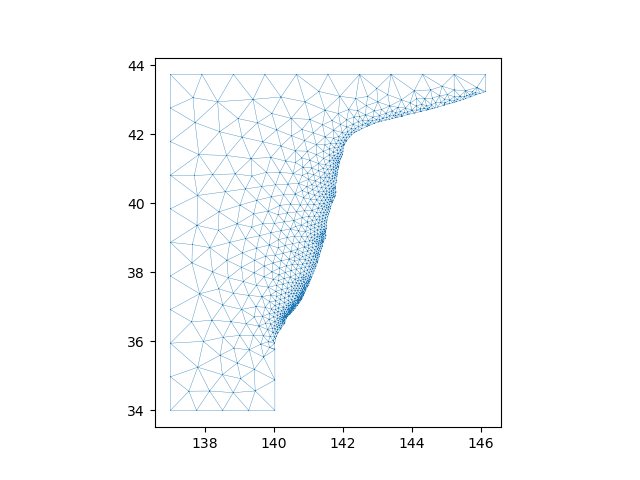

In [10]:
##Mesh the CMI based upon lower depth extent of afterslip ~60km

#sort points by increasing latitude
indicies = np.argsort( depth_contour[:,1] )
depth_contour = depth_contour[indicies]

# separately add on the corners of the CMI
min_lon = 137 # minimum longitude value for corner
min_lat = 34
max_lat = np.max(depth_contour[:,1]+0.5) # maximum latitude for corner

# corner points starting from lower left and moving counterclockwise
corner_points = np.array([[min_lon, min_lat, plane_depth], [depth_contour[0,0], min_lat, plane_depth], [min_lon, max_lat, plane_depth], [np.max(depth_contour[:,0]), max_lat, plane_depth]])

# total points along the perimiter of the CMI mesh
mesh_edge = np.concatenate((depth_contour, corner_points))

# fig, ax = plt.subplots()
# ax.scatter(mesh_edge[:, 0], mesh_edge[:, 1])
# plt.show()

cx = mesh_edge[:,0]
cy = mesh_edge[:,1]
cz = -1*mesh_edge[:,2] # depth is negative

## BEGIN GMSH

char_len = 1 # smaller is good for degrees
n_points = np.shape(depth_contour)[0] # number of depth contour points
num_surf = np.shape(depth_contour)[0]
num_lines = np.shape(mesh_edge)[0] #num lines is the same as the total number of points

if gmsh.isInitialized() == 0:
    gmsh.initialize()
gmsh.option.setNumber("General.Verbosity", 0)
gmsh.clear()

# Define points
gmsh.model.geo.addPoint(cx[-4], cy[-4], cz[-4], char_len, 0) #lower left corner because corner points were added last in the mesh_points
gmsh.model.geo.addPoint(cx[-3], cy[-3], cz[-3], char_len, 1)
for j in range(int(n_points)): # depth contour points
    gmsh.model.geo.addPoint(cx[j], cy[j], cz[j], char_len, j+2) 

gmsh.model.geo.addPoint(cx[-1], cy[-1], cz[-1], char_len, j+3) #upper right corner
gmsh.model.geo.addPoint(cx[-2], cy[-2], cz[-2], char_len, j+4) #upper left corner

# add lines between the points to complete the perimiter
for i in range(int(num_lines-1)):
    gmsh.model.geo.addLine(i, i+1, i)
gmsh.model.geo.addLine(i+1, 0, i+1) #complete the loop

gmsh.model.geo.synchronize()

# define curve loop counterclockwise
gmsh.model.geo.addCurveLoop(list(range(0, i+2)), 1)

gmsh.model.geo.addPlaneSurface([1], 1)

# Finish writing geo attributes
gmsh.model.geo.synchronize()

gmsh.write('horiz' + '.geo_unrolled')

# Generate mesh
gmsh.model.mesh.generate(2) #meshed in spherical because the depth being in km isn't as important when it's flat

gmsh.write('horiz' + '.msh')
gmsh.finalize()  

# Read and parse mesh
fault = dict()
faultobj = meshio.read('horiz' + ".msh") 
fault["points"] = faultobj.points
fault["verts"] = meshio.CellBlock("triangle", faultobj.get_cells_type("triangle")).data
fig, ax = plt.subplots()
# Draw the fault
ax.triplot(fault["points"][:, 0], fault["points"][:, 1], fault["verts"], linewidth=0.25)
ax.set_aspect("equal")
plt.show()



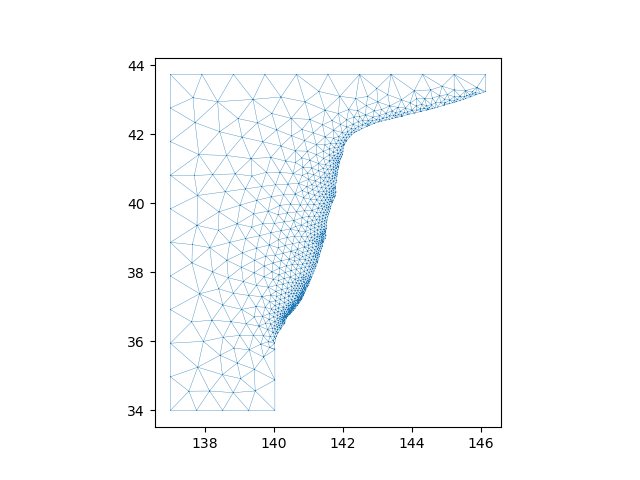

In [11]:
# Read and parse mesh
horiz = dict()
# information about the CMI mesh is read in, and stored in a dictionary just like for fault mesh earlier
horizobj = meshio.read("horiz.msh") 
horiz["points"] = horizobj.points
horiz["verts"] = meshio.CellBlock("triangle", horizobj.get_cells_type("triangle")).data

# Expand mesh coordinates
horiz["lon1"] = horiz["points"][horiz["verts"][:, 0], 0]
horiz["lon2"] = horiz["points"][horiz["verts"][:, 1], 0]
horiz["lon3"] = horiz["points"][horiz["verts"][:, 2], 0]
horiz["lat1"] = horiz["points"][horiz["verts"][:, 0], 1]
horiz["lat2"] = horiz["points"][horiz["verts"][:, 1], 1]
horiz["lat3"] = horiz["points"][horiz["verts"][:, 2], 1]
horiz["dep1"] = horiz["points"][horiz["verts"][:, 0], 2]
horiz["dep2"] = horiz["points"][horiz["verts"][:, 1], 2]
horiz["dep3"] = horiz["points"][horiz["verts"][:, 2], 2]
horiz["centroids"] = np.mean(horiz["points"][horiz["verts"], :], axis=1)

# Cartesian coordinates in meters
horiz["x1"], horiz["y1"], horiz["z1"] = sph2cart(
    horiz["lon1"],
    horiz["lat1"],
    RADIUS_EARTH + KM2M * horiz["dep1"],
)
horiz["x2"], horiz["y2"], horiz["z2"] = sph2cart(
    horiz["lon2"],
    horiz["lat2"],
    RADIUS_EARTH + KM2M * horiz["dep2"],
)
horiz["x3"], horiz["y3"], horiz["z3"] = sph2cart(
    horiz["lon3"],
    horiz["lat3"],
    RADIUS_EARTH + KM2M * horiz["dep3"],
)
# Cartesian triangle centroids
horiz["x_centroid"] = (horiz["x1"] + horiz["x2"] + horiz["x3"]) / 3.0
horiz["y_centroid"] = (horiz["y1"] + horiz["y2"] + horiz["y3"]) / 3.0
horiz["z_centroid"] = (horiz["z1"] + horiz["z2"] + horiz["z3"]) / 3.0

# Cross products for orientations
tri_leg1 = np.transpose([np.deg2rad(horiz["lon2"] - horiz["lon1"]), np.deg2rad(horiz["lat2"] - horiz["lat1"]), (1 + KM2M * horiz["dep2"] / RADIUS_EARTH) - (1 + KM2M * horiz["dep1"] / RADIUS_EARTH)])
tri_leg2 = np.transpose([np.deg2rad(horiz["lon3"] - horiz["lon1"]), np.deg2rad(horiz["lat3"] - horiz["lat1"]), (1 + KM2M * horiz["dep3"] / RADIUS_EARTH) - (1 + KM2M * horiz["dep1"] / RADIUS_EARTH)])
horiz["nv"] = np.cross(tri_leg1, tri_leg2)
azimuth, elevation, r = cart2sph(horiz["nv"][:, 0], horiz["nv"][:, 1], horiz["nv"][:, 2])
horiz["strike"] = wrap2360(-np.rad2deg(azimuth))
horiz["dip"] = 90 - np.rad2deg(elevation)
horiz["dip_flag"] = horiz["dip"] != 90

# Draw the fault 
fig, ax = plt.subplots()
ax.triplot(horiz["points"][:, 0], horiz["points"][:, 1], horiz["verts"], linewidth=0.25)
ax.set_aspect("equal")
plt.show()

### Read postseismic GPS data

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/var/folders/7c/8db84z1953v2yvj0hb957l_h0000gp/T/ipykernel_1855/1991006958.py:2: SyntaxWarning: invalid escape sequence '\s'
  gps = pd.read_table("./cumulative_disp.txt", sep='\s+', header=None, names=colnames)


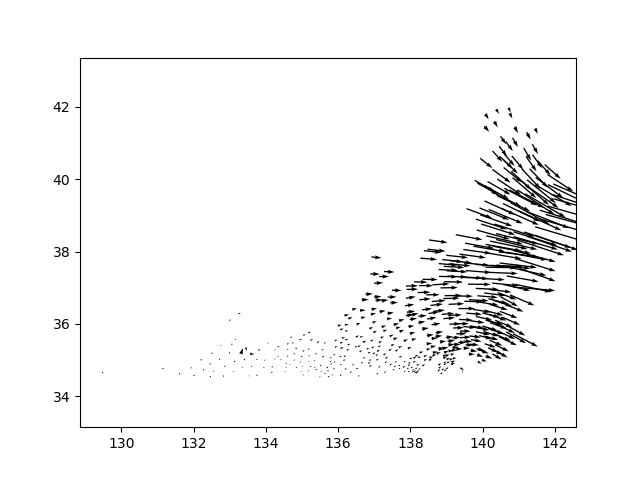

In [12]:
colnames = ["station_ID", 'lon', 'lat', 'east_vel', 'north_vel', 'up_vel']
gps = pd.read_table("./cumulative_disp.txt", sep='\s+', header=None, names=colnames)

# Place stations into single array
# lat, lon, dep, but dep is always zero because they're on the ground
# reshape(3, -1) means put it into 3 rows and as many columns as data points
# then T makes it 3 columns, and as many rows as data points
obsv = np.array([gps.lon, gps.lat, 0*gps.lat]).reshape((3, -1)).T.copy()

plot_vectors = True
if plot_vectors:
    fig, ax = plt.subplots()
    ax.quiver(gps.lon, gps.lat, gps.east_vel, gps.north_vel)
    ax.axis("equal")
    plt.show()

### Concatenate meshes and calculate partial derivatives

In [15]:
import sys
sys.path.append('/Users/anitamiddleton/Documents/python/celeri')

import celeri 
from dataclasses import dataclass

# Force meshes into dataclass, using existing fields
class Mesh:
    def __init__(self, d=None):
        if d is not None:
            for key, value in d.items():
                setattr(self, key, value)

# List of classes
meshes = [Mesh(mesh), Mesh(horiz)]

# Quick config class
@dataclass
class Config:
    material_lambda = 30000000000
    material_mu = 30000000000
config = Config()

# Define indices for meshes in arrays, where each meshes triangle elements begin
n_tri = np.zeros(len(meshes), dtype=int)
for i in range(len(meshes)):
    n_tri[i] = len(meshes[i].lon1)
tri_end_idx = np.cumsum(n_tri) # the last triangle index, the sum of all triangle elem in both meshes
tri_beg_idx = [0, tri_end_idx[0]] # list of indexes, the beginning of the fault mesh elem, beginning of the cmi mesh elem
total_n_tri = tri_end_idx[-1] 
# gets the last element of the summation that makes up total triangles, here, the number of tri elem in the CMI

# Allocate space for slip-to-displacement array
disp_mat = np.zeros((3*len(gps.lon), 3*np.sum(n_tri)))
# Allocate space for slip-to-displacement array
smoothing_mat = np.zeros((3*np.sum(n_tri), 3*np.sum(n_tri)))

# For each mesh, fill in disp_mat with the values and not just zeros
for mesh_idx in range(len(meshes)):
    # Calculate slip to displacement partials, using geographic coordinates
    disp_mat[:, 3*tri_beg_idx[mesh_idx]:3*tri_end_idx[mesh_idx]] = celeri.spatial.get_tde_to_velocities_single_mesh(meshes, gps, config, mesh_idx)
    # Get smoothing operator

    # Indices of shared sides in this mesh
    # find which triangles share sides with which triangles, because in a group, 
    # one triangle gets 3, other three around it get -1, end result is smooth
    share = celeri.spatial.get_shared_sides(meshes[mesh_idx].verts)
    # Distances between centroids of shared elements
    tri_shared_sides_distances = celeri.spatial.get_tri_shared_sides_distances(
            share,
            meshes[mesh_idx].x_centroid,
            meshes[mesh_idx].y_centroid,
            meshes[mesh_idx].z_centroid,
        )
    # Distance-scaled smoothing matrix
    smat = celeri.spatial.get_tri_smoothing_matrix(
            share, tri_shared_sides_distances
        )
    # Insert sparse matrix into full array
    smoothing_mat[3*tri_beg_idx[mesh_idx]:3*tri_end_idx[mesh_idx], 3*tri_beg_idx[mesh_idx]:3*tri_end_idx[mesh_idx]] = smat.toarray()

Calculating cutde partials for triangles: 100%|██████████| 1682/1682 [00:01<00:00, 893.12it/s]


### Assemble matrices, weighting matrix, and data vector

In [18]:
# Assemble matrices
disp_mat = np.nan_to_num(disp_mat)
assembled_mat = np.vstack([disp_mat, smoothing_mat])

# List of smoothing weights to test
smooths = [1e-6, 1e-2, 1e-1]

# Select a smoothing weight and apply to meshes
smoothing_weight = smooths[1]
if np.size(smoothing_weight) != len(meshes):
    smoothing_weight = smoothing_weight*np.ones(len(meshes)) 

# Assemble weighting vector

# Start with unit uncertainties 
# this puts the smoothing weight for the fault mesh and cmi mesh, and leaves gps stations as 1
weights = np.ones((np.shape(assembled_mat)[0], 1))
for mesh_idx in range(len(meshes)):
    weights[3*tri_beg_idx[mesh_idx]:3*tri_end_idx[mesh_idx]] = smoothing_weight[mesh_idx]

# Allocate space for data vector
data_vector = np.zeros((np.shape(assembled_mat)[0], 1))
# Vector of displacements
disp_array = np.array([gps.east_vel, gps.north_vel, gps.up_vel]).reshape((3, -1)).T.copy()
data_vector[0:3*len(disp_array)] = (disp_array.flatten()).reshape((-1,1)) # reshape puts the flattened array into a column

#### Carry out inversion

In [ ]:
# Calculate model covariance
cov = np.linalg.inv((assembled_mat.T * weights.T) @ assembled_mat) 
#nan_val = np.isnan((assembled_mat.T * weights.T) @ assembled_mat)

# Estimate slip using pre-calculated covariance
est_slip = cov @ assembled_mat.T * weights.T @ data_vector 
# Predict displacement at stations
pred_disp = disp_mat.dot(est_slip)
